In [5]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

X = np.load("../Extracted Data/X_features.npy")  # MFCC features
y = np.load("../Extracted Data/y_labels.npy")  # Labels

In [6]:
# LDA Functions
def compute_class_means(X, y):
    class_labels = np.unique(y)
    means = {label: np.mean(X[y == label], axis=0) for label in class_labels}
    return means

def compute_within_class_scatter(X, y, means):
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))
    for label, mean in means.items():
        class_scatter = np.dot((X[y == label] - mean).T, (X[y == label] - mean))
        Sw += class_scatter
    return Sw

def compute_between_class_scatter(X, y, means):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    Sb = np.zeros((n_features, n_features))
    for label, mean in means.items():
        n_samples = X[y == label].shape[0]
        mean_diff = (mean - overall_mean).reshape(-1, 1)
        Sb += n_samples * np.dot(mean_diff, mean_diff.T)
    return Sb

def lda(X, y, num_components):
    means = compute_class_means(X, y)
    Sw = compute_within_class_scatter(X, y, means)
    Sb = compute_between_class_scatter(X, y, means)

    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))
    eigvals = eigvals.real  # Keep only the real parts
    eigvecs = eigvecs.real  # Keep only the real parts

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]
    return eigvecs[:, :num_components]

def project_data(X, eigenvectors):
    return np.dot(X, eigenvectors)

In [7]:
import numpy as np

class SVM:
    def __init__(self, C=1.0, kernel='linear', tol=1e-3, max_iter=1000):
        self.C = C  # Regularization parameter
        self.kernel = self._get_kernel(kernel)
        self.tol = tol  # Tolerance for stopping criteria
        self.max_iter = max_iter  # Max iterations for SMO
        self.alpha = None  # Lagrange multipliers
        self.b = 0  # Bias term
        self.w = None  # Weight vector (for linear kernel)
        self.support_vectors = None  # Store support vectors

    def _get_kernel(self, kernel_type):
        if kernel_type == 'linear':
            return lambda x, y: np.dot(x, y.T)
        elif kernel_type == 'rbf':
            return lambda x, y, gamma=0.5: np.exp(-gamma * np.linalg.norm(x - y) ** 2)
        else:
            raise ValueError("Unsupported kernel. Use 'linear' or 'rbf'.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.where(y == 0, -1, 1)  # Convert to {-1,1} labels
        self.alpha = np.zeros(n_samples)
        self.b = 0

        # Precompute the kernel matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])

        # SMO Algorithm
        for _ in range(self.max_iter):
            alpha_prev = np.copy(self.alpha)

            for i in range(n_samples):
                Ei = self._compute_error(X, y, K, i)
                if (y[i] * Ei < -self.tol and self.alpha[i] < self.C) or (y[i] * Ei > self.tol and self.alpha[i] > 0):
                    j = np.random.choice([k for k in range(n_samples) if k != i])  # Select random j != i
                    Ej = self._compute_error(X, y, K, j)

                    alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

                    # Compute L and H
                    if y[i] != y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])

                    if L == H:
                        continue

                    # Compute eta
                    eta = 2 * K[i, j] - K[i, i] - K[j, j]
                    if eta >= 0:
                        continue

                    # Update alpha[j]
                    self.alpha[j] -= y[j] * (Ei - Ej) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)

                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue

                    # Update alpha[i]
                    self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])

                    # Compute b values
                    b1 = self.b - Ei - y[i] * (self.alpha[i] - alpha_i_old) * K[i, i] - y[j] * (self.alpha[j] - alpha_j_old) * K[i, j]
                    b2 = self.b - Ej - y[i] * (self.alpha[i] - alpha_i_old) * K[i, j] - y[j] * (self.alpha[j] - alpha_j_old) * K[j, j]

                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

            # Convergence check
            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tol:
                break

        # Compute final weight vector for linear kernel
        if self.kernel.__name__ == '<lambda>':
            self.w = np.sum((self.alpha * y).reshape(-1, 1) * X, axis=0)

        # Support vectors
        self.support_vectors = X[self.alpha > 0]

    def _compute_error(self, X, y, K, i):
        return np.sum(self.alpha * y * K[:, i]) + self.b - y[i]

    def predict(self, X):
        if self.kernel.__name__ == '<lambda>':  # Linear kernel
            return np.sign(np.dot(X, self.w) + self.b)
        else:
            predictions = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                predictions[i] = np.sign(np.sum(self.alpha * y * self.kernel(X[i], self.support_vectors)) + self.b)
            return predictions


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=42)
y = np.where(y == 0, -1, 1)  # Convert labels to {-1,1}

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ----------- LDA Implementation -----------
def compute_class_means(X, y):
    class_labels = np.unique(y)
    means = {label: np.mean(X[y == label], axis=0) for label in class_labels}
    return means

def compute_within_class_scatter(X, y, means):
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))
    for label, mean in means.items():
        class_scatter = np.dot((X[y == label] - mean).T, (X[y == label] - mean))
        Sw += class_scatter
    return Sw

def compute_between_class_scatter(X, y, means):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    Sb = np.zeros((n_features, n_features))
    for label, mean in means.items():
        n_samples = X[y == label].shape[0]
        mean_diff = (mean - overall_mean).reshape(-1, 1)
        Sb += n_samples * np.dot(mean_diff, mean_diff.T)
    return Sb

def lda(X, y, num_components=1):
    means = compute_class_means(X, y)
    Sw = compute_within_class_scatter(X, y, means)
    Sb = compute_between_class_scatter(X, y, means)

    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))
    eigvals = eigvals.real  # Keep real parts
    eigvecs = eigvecs.real  # Keep real parts

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]
    return eigvecs[:, :num_components]

def project_data(X, eigenvectors):
    return np.dot(X, eigenvectors)

# Apply LDA
lda_vectors = lda(X_train, y_train, num_components=1)
X_train_lda = project_data(X_train, lda_vectors)
X_val_lda = project_data(X_val, lda_vectors)
X_test_lda = project_data(X_test, lda_vectors)

# ----------- Train SVM from Scratch -----------
class SVM:
    def __init__(self, C=1.0, lr=0.001, epochs=1000):
        self.C = C
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                if y[i] * (np.dot(x_i, self.w) + self.b) < 1:
                    self.w += self.lr * (y[i] * x_i + (-2 * self.C * self.w))
                    self.b += self.lr * y[i]
                else:
                    self.w += self.lr * (-2 * self.C * self.w)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# Train SVM model
svm = SVM(C=1.0, lr=0.001, epochs=1000)
svm.fit(X_train_lda, y_train)

# Predictions
y_train_pred = svm.predict(X_train_lda)
y_val_pred = svm.predict(X_val_lda)
y_test_pred = svm.predict(X_test_lda)

# Compute accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")



Train Accuracy: 91.43%
Validation Accuracy: 97.78%
Test Accuracy: 95.56%


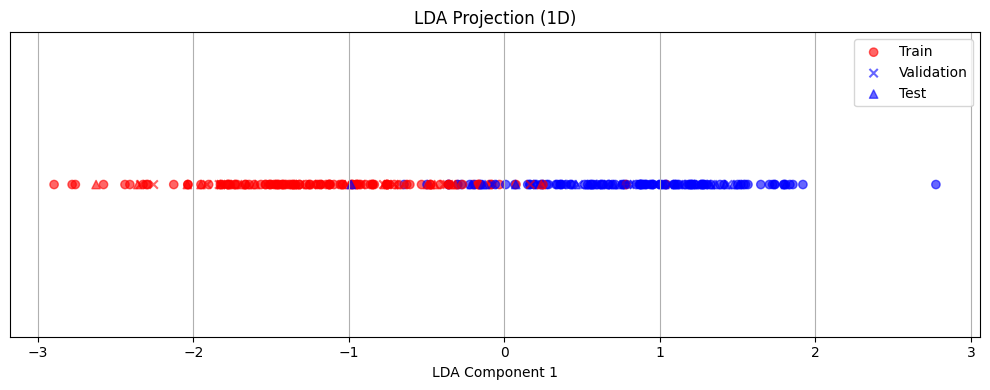

In [9]:
# 1D Projection Plot
plt.figure(figsize=(10, 4))
plt.scatter(X_train_lda, np.zeros_like(X_train_lda), c=y_train, cmap='bwr', alpha=0.6, label="Train", marker='o')
plt.scatter(X_val_lda, np.zeros_like(X_val_lda), c=y_val, cmap='bwr', alpha=0.6, label="Val", marker='x')
plt.scatter(X_test_lda, np.zeros_like(X_test_lda), c=y_test, cmap='bwr', alpha=0.6, label="Test", marker='^')
plt.title("LDA Projection (1D)")
plt.xlabel("LDA Component 1")
plt.yticks([])  # Hide y-axis
plt.legend(["Train", "Validation", "Test"])
plt.grid(True)
plt.tight_layout()
plt.show()


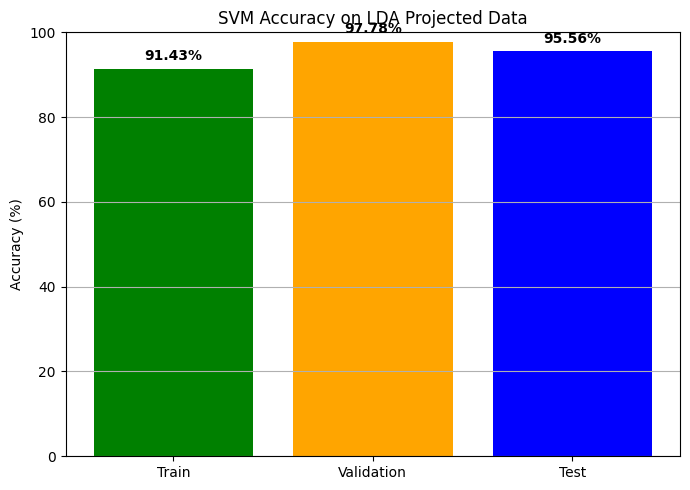

In [10]:
# Accuracy Comparison Bar Plot
sets = ['Train', 'Validation', 'Test']
accuracies = [train_acc * 100, val_acc * 100, test_acc * 100]

plt.figure(figsize=(7, 5))
plt.bar(sets, accuracies, color=['green', 'orange', 'blue'])
plt.ylim(0, 100)
plt.title("SVM Accuracy on LDA Projected Data")
plt.ylabel("Accuracy (%)")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f"{acc:.2f}%", ha='center', fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
